# 3D Solid Mechanics

* Open Cascade Techonology geometry kernel
* Netgen mesh generator
* NGSolve Finite Element libraray

In [1]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw 

In [2]:
box = Box((0,0,0), (3,0.6,1))
box.faces.name="outer"
cyl = sum( [Cylinder((0.5+i,0,0.5), Y, 0.25,0.8) for i in range(3)] )
cyl.faces.name="cyl"
geo = box-cyl

ea = { "euler_angles" : [-70,5,30] }
Draw(geo, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

find edges between box and cylinder, and build chamfers:

In [3]:
cylboxedges = geo.faces["outer"].edges * geo.faces["cyl"].edges
cylboxedges.name = "cylbox"
geo = geo.MakeChamfer(cylboxedges, 0.03)

name faces for boundary conditions:

In [4]:
geo.faces.Min(X).name = "fix"
geo.faces.Max(X).name = "force"

Draw(geo, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [5]:
mesh = Mesh(OCCGeometry(geo).GenerateMesh(maxh=0.1)).Curve(3)
Draw (mesh, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'camera': {'euler_angles': [-…

## Linear elasticity

Displacement: $u : \Omega \rightarrow {\mathbb R}^3$

Linear strain:

$$
\varepsilon(u) := \tfrac{1}{2} ( \nabla u + (\nabla u)^T )
$$

Stress by Hooke's law:

$$
\sigma = 2 \mu \varepsilon + \lambda \operatorname{tr} \varepsilon I
$$

Equilibrium of forces:

$$
\operatorname{div} \sigma = f
$$

Displacement boundary conditions:

$$
u = u_D \qquad \text{on} \, \Gamma_D
$$

Traction boundary conditions:

$$
\sigma n = g \qquad \text{on} \, \Gamma_N
$$

## Variational formulation:
 
Find: $u \in H^1(\Omega)^3$ such that $u = u_D$ on $\Gamma_D$

$$
\int_\Omega \sigma(\varepsilon(u)) : \varepsilon(v) \, dx = \int_\Omega f v dx + \int_{\Gamma_N} g v ds
$$

holds for all $v = 0$ on $\Gamma_D$.

In [6]:
E, nu = 210, 0.2
mu  = E / 2 / (1+nu)
lam = E * nu / ((1+nu)*(1-2*nu))

def Stress(strain):
    return 2*mu*strain + lam*Trace(strain)*Id(3)    

In [7]:
fes = VectorH1(mesh, order=3, dirichlet="fix")
u,v = fes.TnT()
gfu = GridFunction(fes)

with TaskManager():
    a = BilinearForm(InnerProduct(Stress(Sym(Grad(u))), Sym(Grad(v))).Compile()*dx)
    pre = preconditioners.BDDC(a)
    a.Assemble()

In [8]:
force = CF( (1e-3,0,0) )
f = LinearForm(force*v*ds("force")).Assemble()

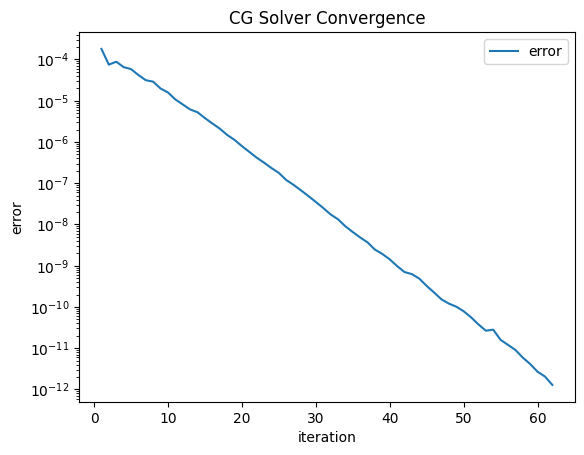

<Figure size 640x480 with 0 Axes>

In [9]:
inv = solvers.CGSolver(a.mat, pre, plotrates=True, tol=1e-8)
gfu.vec.data = inv * f.vec

In [10]:
with TaskManager():
    fesstress = MatrixValued(H1(mesh,order=3), symmetric=True)
    gfstress = GridFunction(fesstress)
    gfstress.Interpolate (Stress(Sym(Grad(gfu))))

In [11]:
Draw (gfu, mesh, deformation=True, scale=3e4, draw_vol=False, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'camera': {'euler_angles': [-…

In [12]:
Draw (Norm(gfstress), mesh, deformation=1e4*gfu, draw_vol=False, order=3, **ea);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'camera': {'euler_angles': [-…